# Prompted Segmentation for Drywall QA

## Overview
A text-conditioned segmentation model fine-tuned on drywall inspection images.
Given an image and a natural-language prompt, the model produces a binary mask
highlighting the region of interest.

Supported prompts:
- `segment taping area` → highlights drywall joints and seams
- `segment crack`       → highlights wall cracks and fractures

---

## Model
- **Architecture:** CLIPSeg (CIDAS/clipseg-rd64-refined)
- **Base model:** CLIP ViT-B/16 encoder + lightweight CNN decoder
- **Strategy:** Frozen CLIP encoder, fine-tuned decoder only
- **Loss:** BCE + Dice combined loss
- **Optimizer:** AdamW (lr=1e-4, weight_decay=1e-4)
- **Scheduler:** CosineAnnealingLR
- **Epochs:** 10
- **Batch size:** 8
- **Image size:** 352×352
- **Device:** NVIDIA T4 GPU (Google Colab)

---

## Reproducibility
All random seeds set to **42** at the start of training:
```python
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
```

---

## Datasets

| Dataset | Source | Task | Split |
|---|---|---|---|
| Drywall Join Detect | roboflow: objectdetect-pu6rn | Taping Area | Train: 936, Valid: 250 |
| Crack Detection | roboflow: university-bswxt | Cracks | Train: 991, Valid: 248 |

**Note:** Both datasets were originally object-detection format (bounding boxes).
Bounding boxes were converted to binary masks using filled rectangle regions.
Dataset 2 had no validation split — manually split 80/20 using sklearn with seed=42.

---

## Results

| Class   | mIoU   | Dice   | Samples |
|---------|--------|--------|---------|
| Taping  | 0.5218 | 0.6727 | 250     |
| Crack   | 0.5676 | 0.7139 | 248     |
| Overall | 0.5446 | 0.6932 | 498     |

**Best validation IoU:** 0.5468

---

## Output Masks
- Format: PNG, single-channel, values {0, 255}
- Same spatial size as source image
- Naming: `{image_id}__{prompt}.png`
- Example: `IMG_001__segment_crack.png`

---

## Project Structure
```
drywall-qa/
├── data/
│   ├── dataset1_taping_raw/       # Raw Roboflow download
│   ├── dataset1_taping/           # Converted masks
│   ├── dataset2_cracks_raw/       # Raw Roboflow download
│   └── dataset2_cracks/           # Converted masks + split
├── checkpoints/
│   ├── clipseg_best.pt            # Best model weights
│   └── training_curves.png        # Loss/IoU/Dice plots
└── predictions/
    ├── taping/                    # Taping prediction masks
    ├── cracks/                    # Crack prediction masks
    ├── taping_examples.png        # Visual examples
    └── crack_examples.png         # Visual examples
```

---

## Requirements
```
torch
torchvision
transformers
roboflow
opencv-python-headless
albumentations
scikit-learn
matplotlib
tqdm
pillow
```

---

## Runtime & Footprint
| Metric | Value |
|---|---|
| Training time | ~35 minutes (T4 GPU) |
| Avg inference time | ~0.18 sec/image |
| Model size (clipseg-rd64-refined) | ~230 MB |
| Checkpoint size (decoder only) | ~45 MB |

---

## Failure Cases
- Thin hairline cracks are sometimes missed (low contrast)
- Taping areas with no visible seam texture are under-segmented
- Bounding box masks as GT introduce noise — pixel-level annotations would improve results



Installs & Mount Drive

In [1]:
!pip install -q transformers opencv-python-headless \
             albumentations scikit-learn matplotlib tqdm pillow

from google.colab import drive
drive.mount('/content/drive')

BASE = '/content/drive/MyDrive/drywall-qa'
print("✅ Drive mounted")

Mounted at /content/drive
✅ Drive mounted


Imports & Constants

In [2]:
import os, random, json, time
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Paths — data already downloaded
D1_TRAIN_IMGS  = f"{BASE}/data/dataset1_taping_raw/train"
D1_TRAIN_MASKS = f"{BASE}/data/dataset1_taping/masks/train"
D1_VALID_IMGS  = f"{BASE}/data/dataset1_taping_raw/valid"
D1_VALID_MASKS = f"{BASE}/data/dataset1_taping/masks/valid"
D2_TRAIN_IMGS  = f"{BASE}/data/dataset2_cracks/images/train"
D2_TRAIN_MASKS = f"{BASE}/data/dataset2_cracks/masks/train_final"
D2_VALID_IMGS  = f"{BASE}/data/dataset2_cracks/images/valid"
D2_VALID_MASKS = f"{BASE}/data/dataset2_cracks/masks/valid"

PROMPTS = {
    'taping': ["segment taping area", "segment joint tape",
               "segment drywall seam", "segment wall joint"],
    'crack':  ["segment crack", "segment wall crack",
               "segment surface crack", "segment fracture"]
}

print(f"✅ Device : {DEVICE}")
print(f"✅ Imports done")

✅ Device : cuda
✅ Imports done


 Dataset Class

In [3]:
class DrywallDataset(Dataset):
    def __init__(self, d1_imgs, d1_masks, d2_imgs, d2_masks, image_size=352):
        self.image_size = image_size
        self.samples    = []

        for imgs_dir, masks_dir, label in [
            (d1_imgs, d1_masks, 'taping'),
            (d2_imgs, d2_masks, 'crack')
        ]:
            if not os.path.exists(imgs_dir): continue
            for img_file in os.listdir(imgs_dir):
                if not img_file.lower().endswith(('.jpg','.jpeg','.png')):
                    continue
                mask_path = os.path.join(masks_dir,
                            os.path.splitext(img_file)[0] + '.png')
                if os.path.exists(mask_path):
                    self.samples.append({
                        'image': os.path.join(imgs_dir, img_file),
                        'mask' : mask_path,
                        'label': label
                    })

        print(f"✅ Dataset: {len(self.samples)} samples loaded")

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        s      = self.samples[idx]
        image  = Image.open(s['image']).convert('RGB')
        mask   = Image.open(s['mask']).convert('L')
        image  = image.resize((self.image_size, self.image_size), Image.BILINEAR)
        mask   = mask.resize((self.image_size, self.image_size), Image.NEAREST)
        image  = T.ToTensor()(image)
        mask   = torch.tensor(np.array(mask), dtype=torch.float32) / 255.0
        prompt = random.choice(PROMPTS[s['label']])
        return image, prompt, mask, s['label']

print("✅ Dataset class defined")

✅ Dataset class defined


Loss & Metrics

In [4]:
def dice_loss(pred, target, smooth=1.0):
    pred   = torch.sigmoid(pred).view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 1 - (2 * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def bce_dice_loss(pred, target):
    if pred.shape != target.shape:
        pred = F.interpolate(pred.unsqueeze(1), size=target.shape[-2:],
                             mode='bilinear', align_corners=False).squeeze(1)
    return F.binary_cross_entropy_with_logits(pred, target) + dice_loss(pred, target)

def compute_metrics(pred, target, threshold=0.5):
    pred = torch.sigmoid(pred)
    if pred.shape != target.shape:
        pred = F.interpolate(pred.unsqueeze(1), size=target.shape[-2:],
                             mode='bilinear', align_corners=False).squeeze(1)
    pred_bin     = (pred > threshold).float()
    intersection = (pred_bin * target).sum()
    union        = (pred_bin + target).clamp(0, 1).sum()
    iou          = (intersection + 1e-6) / (union + 1e-6)
    dice         = (2 * intersection + 1e-6) / (pred_bin.sum() + target.sum() + 1e-6)
    return iou.item(), dice.item()

print("✅ Loss & metrics defined")

✅ Loss & metrics defined


Train Function (one seed)

In [5]:
def train_one_seed(seed, epochs=20, lr=1e-4, batch_size=16):

    # Set seed
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed(seed)
    print(f"\n{'='*60}")
    print(f"Training with SEED = {seed}")
    print(f"{'='*60}")

    # Paths for this seed
    ckpt_dir = f"{BASE}/checkpoints/seed_{seed}"
    os.makedirs(ckpt_dir, exist_ok=True)
    best_path = f"{ckpt_dir}/clipseg_best.pt"
    last_path = f"{ckpt_dir}/clipseg_last.pt"
    hist_path = f"{ckpt_dir}/history.json"

    # DataLoaders
    train_ds = DrywallDataset(D1_TRAIN_IMGS, D1_TRAIN_MASKS,
                              D2_TRAIN_IMGS, D2_TRAIN_MASKS)
    valid_ds = DrywallDataset(D1_VALID_IMGS, D1_VALID_MASKS,
                              D2_VALID_IMGS, D2_VALID_MASKS)

    train_loader = DataLoader(train_ds, batch_size=batch_size,
                              shuffle=True,  num_workers=2)
    valid_loader = DataLoader(valid_ds, batch_size=batch_size,
                              shuffle=False, num_workers=2)

    # Fresh model for each seed
    processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
    model     = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")
    model     = model.to(DEVICE)

    # Freeze CLIP encoder
    for name, param in model.named_parameters():
        if 'clip' in name.lower():
            param.requires_grad = False

    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=lr, weight_decay=1e-4
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    # Resume if history exists
    if os.path.exists(hist_path):
        with open(hist_path) as f:
            history = json.load(f)
        start_epoch = len(history['train_loss'])
        best_iou    = max(history['val_iou']) if history['val_iou'] else 0.0
        if os.path.exists(last_path):
            model.load_state_dict(torch.load(last_path, map_location=DEVICE))
        print(f"📂 Resuming from epoch {start_epoch+1}")
    else:
        history     = {'train_loss':[], 'val_loss':[],
                       'val_iou':[], 'val_dice':[], 'epoch_time':[]}
        start_epoch = 0
        best_iou    = 0.0

    for epoch in range(start_epoch, epochs):
        t0 = time.time()

        # ── Train ──────────────────────────────────
        model.train()
        train_loss = 0.0
        for images, prompts, masks, _ in tqdm(
                train_loader, desc=f"Seed {seed} | Epoch {epoch+1}/{epochs} [Train]"):
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            inputs = processor(
                text=list(prompts),
                images=[T.ToPILImage()(img.cpu()) for img in images],
                return_tensors="pt", padding=True
            ).to(DEVICE)
            loss = bce_dice_loss(model(**inputs).logits, masks)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        # ── Validate ───────────────────────────────
        model.eval()
        val_loss = val_iou = val_dice = 0.0
        with torch.no_grad():
            for images, prompts, masks, _ in tqdm(
                    valid_loader, desc=f"Seed {seed} | Epoch {epoch+1}/{epochs} [Valid]"):
                images, masks = images.to(DEVICE), masks.to(DEVICE)
                inputs = processor(
                    text=list(prompts),
                    images=[T.ToPILImage()(img.cpu()) for img in images],
                    return_tensors="pt", padding=True
                ).to(DEVICE)
                logits       = model(**inputs).logits
                iou, dice    = compute_metrics(logits, masks)
                val_loss    += bce_dice_loss(logits, masks).item()
                val_iou     += iou
                val_dice    += dice
        val_loss /= len(valid_loader)
        val_iou  /= len(valid_loader)
        val_dice /= len(valid_loader)
        scheduler.step()

        # ── Save checkpoints ───────────────────────
        if val_iou > best_iou:
            best_iou = val_iou
            torch.save(model.state_dict(), best_path)
            print(f"   💾 Best model saved! IoU: {best_iou:.4f}")
        torch.save(model.state_dict(), last_path)

        # ── Save history after every epoch ─────────
        epoch_time = time.time() - t0
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_iou'].append(val_iou)
        history['val_dice'].append(val_dice)
        history['epoch_time'].append(epoch_time)
        with open(hist_path, 'w') as f:
            json.dump(history, f, indent=2)

        print(f"Epoch {epoch+1:02d}/{epochs} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"Val IoU: {val_iou:.4f} | "
              f"Val Dice: {val_dice:.4f} | "
              f"Time: {epoch_time:.1f}s")

    print(f"\n✅ Seed {seed} done! Best IoU: {best_iou:.4f}")
    print(f"   Saved to: {ckpt_dir}")
    return history, best_iou

print("✅ Train function defined")

✅ Train function defined


Run Training Across Multiple Seeds

In [6]:
#SEEDS  = [42, 123, 7]
SEEDS  = [123, 7]
EPOCHS = 20

all_results = {}

for seed in SEEDS:
    history, best_iou = train_one_seed(seed=seed, epochs=EPOCHS)
    all_results[seed] = {'history': history, 'best_iou': best_iou}
    print(f"\n🏁 Seed {seed} complete — Best IoU: {best_iou:.4f}\n")

print("\n" + "="*50)
print("ALL SEEDS COMPLETE")
print("="*50)
for seed, res in all_results.items():
    print(f"Seed {seed:>4} → Best IoU: {res['best_iou']:.4f}")

best_seed = max(all_results, key=lambda s: all_results[s]['best_iou'])
print(f"\n Best seed overall: {best_seed}  (IoU: {all_results[best_seed]['best_iou']:.4f})")


Training with SEED = 123
✅ Dataset: 1927 samples loaded
✅ Dataset: 498 samples loaded


preprocessor_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

The image processor of type `ViTImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/974 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/603M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/462 [00:00<?, ?it/s]

CLIPSegForImageSegmentation LOAD REPORT from: CIDAS/clipseg-rd64-refined
Key                                       | Status     |  | 
------------------------------------------+------------+--+-
clip.vision_model.embeddings.position_ids | UNEXPECTED |  | 
clip.text_model.embeddings.position_ids   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


📂 Resuming from epoch 12


Seed 123 | Epoch 12/20 [Train]: 100%|██████████| 121/121 [16:41<00:00,  8.28s/it]
Seed 123 | Epoch 12/20 [Valid]: 100%|██████████| 32/32 [05:30<00:00, 10.34s/it]


   💾 Best model saved! IoU: 0.5523
Epoch 12/20 | Train Loss: 0.4772 | Val Loss: 0.5762 | Val IoU: 0.5523 | Val Dice: 0.7094 | Time: 1346.1s


Seed 123 | Epoch 13/20 [Train]: 100%|██████████| 121/121 [01:53<00:00,  1.06it/s]
Seed 123 | Epoch 13/20 [Valid]: 100%|██████████| 32/32 [00:28<00:00,  1.11it/s]


   💾 Best model saved! IoU: 0.5564
Epoch 13/20 | Train Loss: 0.4583 | Val Loss: 0.5752 | Val IoU: 0.5564 | Val Dice: 0.7125 | Time: 148.9s


Seed 123 | Epoch 14/20 [Train]: 100%|██████████| 121/121 [01:53<00:00,  1.07it/s]
Seed 123 | Epoch 14/20 [Valid]: 100%|██████████| 32/32 [00:29<00:00,  1.10it/s]


   💾 Best model saved! IoU: 0.5688
Epoch 14/20 | Train Loss: 0.4470 | Val Loss: 0.5588 | Val IoU: 0.5688 | Val Dice: 0.7227 | Time: 147.2s


Seed 123 | Epoch 15/20 [Train]: 100%|██████████| 121/121 [01:51<00:00,  1.08it/s]
Seed 123 | Epoch 15/20 [Valid]: 100%|██████████| 32/32 [00:29<00:00,  1.10it/s]


Epoch 15/20 | Train Loss: 0.4385 | Val Loss: 0.5626 | Val IoU: 0.5616 | Val Dice: 0.7168 | Time: 142.9s


Seed 123 | Epoch 16/20 [Train]: 100%|██████████| 121/121 [01:46<00:00,  1.13it/s]
Seed 123 | Epoch 16/20 [Valid]: 100%|██████████| 32/32 [00:29<00:00,  1.10it/s]


Epoch 16/20 | Train Loss: 0.4276 | Val Loss: 0.5664 | Val IoU: 0.5605 | Val Dice: 0.7157 | Time: 140.2s


Seed 123 | Epoch 17/20 [Train]: 100%|██████████| 121/121 [01:48<00:00,  1.12it/s]
Seed 123 | Epoch 17/20 [Valid]: 100%|██████████| 32/32 [00:29<00:00,  1.08it/s]


   💾 Best model saved! IoU: 0.5727
Epoch 17/20 | Train Loss: 0.4200 | Val Loss: 0.5549 | Val IoU: 0.5727 | Val Dice: 0.7258 | Time: 142.9s


Seed 123 | Epoch 18/20 [Train]: 100%|██████████| 121/121 [01:52<00:00,  1.07it/s]
Seed 123 | Epoch 18/20 [Valid]: 100%|██████████| 32/32 [00:28<00:00,  1.11it/s]


   💾 Best model saved! IoU: 0.5767
Epoch 18/20 | Train Loss: 0.4106 | Val Loss: 0.5543 | Val IoU: 0.5767 | Val Dice: 0.7291 | Time: 147.9s


Seed 123 | Epoch 19/20 [Train]: 100%|██████████| 121/121 [01:54<00:00,  1.05it/s]
Seed 123 | Epoch 19/20 [Valid]: 100%|██████████| 32/32 [00:28<00:00,  1.12it/s]


Epoch 19/20 | Train Loss: 0.4017 | Val Loss: 0.5602 | Val IoU: 0.5710 | Val Dice: 0.7243 | Time: 145.7s


Seed 123 | Epoch 20/20 [Train]: 100%|██████████| 121/121 [01:49<00:00,  1.11it/s]
Seed 123 | Epoch 20/20 [Valid]: 100%|██████████| 32/32 [00:28<00:00,  1.12it/s]


   💾 Best model saved! IoU: 0.5804
Epoch 20/20 | Train Loss: 0.3936 | Val Loss: 0.5486 | Val IoU: 0.5804 | Val Dice: 0.7319 | Time: 143.0s

✅ Seed 123 done! Best IoU: 0.5804
   Saved to: /content/drive/MyDrive/drywall-qa/checkpoints/seed_123

🏁 Seed 123 complete — Best IoU: 0.5804


Training with SEED = 7
✅ Dataset: 1927 samples loaded
✅ Dataset: 498 samples loaded


Loading weights:   0%|          | 0/462 [00:00<?, ?it/s]

CLIPSegForImageSegmentation LOAD REPORT from: CIDAS/clipseg-rd64-refined
Key                                       | Status     |  | 
------------------------------------------+------------+--+-
clip.vision_model.embeddings.position_ids | UNEXPECTED |  | 
clip.text_model.embeddings.position_ids   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Seed 7 | Epoch 1/20 [Train]: 100%|██████████| 121/121 [01:54<00:00,  1.05it/s]
Seed 7 | Epoch 1/20 [Valid]: 100%|██████████| 32/32 [00:28<00:00,  1.11it/s]


   💾 Best model saved! IoU: 0.3255
Epoch 01/20 | Train Loss: 0.9643 | Val Loss: 0.8910 | Val IoU: 0.3255 | Val Dice: 0.4606 | Time: 150.1s


Seed 7 | Epoch 2/20 [Train]: 100%|██████████| 121/121 [01:45<00:00,  1.15it/s]
Seed 7 | Epoch 2/20 [Valid]: 100%|██████████| 32/32 [00:27<00:00,  1.15it/s]


   💾 Best model saved! IoU: 0.4364
Epoch 02/20 | Train Loss: 0.7258 | Val Loss: 0.7566 | Val IoU: 0.4364 | Val Dice: 0.6003 | Time: 137.9s


Seed 7 | Epoch 3/20 [Train]: 100%|██████████| 121/121 [01:51<00:00,  1.08it/s]
Seed 7 | Epoch 3/20 [Valid]: 100%|██████████| 32/32 [00:28<00:00,  1.13it/s]


   💾 Best model saved! IoU: 0.4724
Epoch 03/20 | Train Loss: 0.6390 | Val Loss: 0.6965 | Val IoU: 0.4724 | Val Dice: 0.6382 | Time: 145.1s


Seed 7 | Epoch 4/20 [Train]: 100%|██████████| 121/121 [01:49<00:00,  1.10it/s]
Seed 7 | Epoch 4/20 [Valid]: 100%|██████████| 32/32 [00:28<00:00,  1.13it/s]


   💾 Best model saved! IoU: 0.4894
Epoch 04/20 | Train Loss: 0.5998 | Val Loss: 0.6663 | Val IoU: 0.4894 | Val Dice: 0.6538 | Time: 143.0s


Seed 7 | Epoch 5/20 [Train]: 100%|██████████| 121/121 [01:50<00:00,  1.10it/s]
Seed 7 | Epoch 5/20 [Valid]: 100%|██████████| 32/32 [00:29<00:00,  1.09it/s]


   💾 Best model saved! IoU: 0.5130
Epoch 05/20 | Train Loss: 0.5693 | Val Loss: 0.6444 | Val IoU: 0.5130 | Val Dice: 0.6753 | Time: 146.2s


Seed 7 | Epoch 6/20 [Train]: 100%|██████████| 121/121 [01:53<00:00,  1.07it/s]
Seed 7 | Epoch 6/20 [Valid]: 100%|██████████| 32/32 [00:28<00:00,  1.13it/s]


Epoch 06/20 | Train Loss: 0.5498 | Val Loss: 0.6345 | Val IoU: 0.5081 | Val Dice: 0.6709 | Time: 145.6s


Seed 7 | Epoch 7/20 [Train]: 100%|██████████| 121/121 [01:48<00:00,  1.12it/s]
Seed 7 | Epoch 7/20 [Valid]: 100%|██████████| 32/32 [00:28<00:00,  1.12it/s]


   💾 Best model saved! IoU: 0.5191
Epoch 07/20 | Train Loss: 0.5303 | Val Loss: 0.6257 | Val IoU: 0.5191 | Val Dice: 0.6810 | Time: 141.7s


Seed 7 | Epoch 8/20 [Train]: 100%|██████████| 121/121 [01:52<00:00,  1.08it/s]
Seed 7 | Epoch 8/20 [Valid]: 100%|██████████| 32/32 [00:28<00:00,  1.13it/s]


   💾 Best model saved! IoU: 0.5322
Epoch 08/20 | Train Loss: 0.5128 | Val Loss: 0.6053 | Val IoU: 0.5322 | Val Dice: 0.6919 | Time: 146.3s


Seed 7 | Epoch 9/20 [Train]: 100%|██████████| 121/121 [01:52<00:00,  1.08it/s]
Seed 7 | Epoch 9/20 [Valid]: 100%|██████████| 32/32 [00:29<00:00,  1.09it/s]


Epoch 09/20 | Train Loss: 0.4996 | Val Loss: 0.6108 | Val IoU: 0.5230 | Val Dice: 0.6842 | Time: 145.7s


Seed 7 | Epoch 10/20 [Train]: 100%|██████████| 121/121 [01:48<00:00,  1.12it/s]
Seed 7 | Epoch 10/20 [Valid]: 100%|██████████| 32/32 [00:29<00:00,  1.08it/s]


   💾 Best model saved! IoU: 0.5352
Epoch 10/20 | Train Loss: 0.4862 | Val Loss: 0.5998 | Val IoU: 0.5352 | Val Dice: 0.6947 | Time: 142.5s


Seed 7 | Epoch 11/20 [Train]: 100%|██████████| 121/121 [01:53<00:00,  1.07it/s]
Seed 7 | Epoch 11/20 [Valid]: 100%|██████████| 32/32 [00:29<00:00,  1.10it/s]


   💾 Best model saved! IoU: 0.5498
Epoch 11/20 | Train Loss: 0.4797 | Val Loss: 0.5840 | Val IoU: 0.5498 | Val Dice: 0.7071 | Time: 149.5s


Seed 7 | Epoch 12/20 [Train]: 100%|██████████| 121/121 [01:53<00:00,  1.07it/s]
Seed 7 | Epoch 12/20 [Valid]: 100%|██████████| 32/32 [00:28<00:00,  1.11it/s]


Epoch 12/20 | Train Loss: 0.4676 | Val Loss: 0.5821 | Val IoU: 0.5486 | Val Dice: 0.7062 | Time: 144.3s


Seed 7 | Epoch 13/20 [Train]: 100%|██████████| 121/121 [01:47<00:00,  1.12it/s]
Seed 7 | Epoch 13/20 [Valid]: 100%|██████████| 32/32 [00:28<00:00,  1.13it/s]


Epoch 13/20 | Train Loss: 0.4617 | Val Loss: 0.5860 | Val IoU: 0.5452 | Val Dice: 0.7033 | Time: 138.5s


Seed 7 | Epoch 14/20 [Train]: 100%|██████████| 121/121 [01:48<00:00,  1.11it/s]
Seed 7 | Epoch 14/20 [Valid]: 100%|██████████| 32/32 [00:28<00:00,  1.12it/s]


Epoch 14/20 | Train Loss: 0.4553 | Val Loss: 0.5825 | Val IoU: 0.5483 | Val Dice: 0.7057 | Time: 139.6s


Seed 7 | Epoch 15/20 [Train]: 100%|██████████| 121/121 [01:46<00:00,  1.13it/s]
Seed 7 | Epoch 15/20 [Valid]: 100%|██████████| 32/32 [00:28<00:00,  1.11it/s]


   💾 Best model saved! IoU: 0.5510
Epoch 15/20 | Train Loss: 0.4520 | Val Loss: 0.5776 | Val IoU: 0.5510 | Val Dice: 0.7081 | Time: 141.8s


Seed 7 | Epoch 16/20 [Train]: 100%|██████████| 121/121 [01:52<00:00,  1.07it/s]
Seed 7 | Epoch 16/20 [Valid]: 100%|██████████| 32/32 [00:28<00:00,  1.13it/s]


   💾 Best model saved! IoU: 0.5550
Epoch 16/20 | Train Loss: 0.4488 | Val Loss: 0.5739 | Val IoU: 0.5550 | Val Dice: 0.7114 | Time: 145.9s


Seed 7 | Epoch 17/20 [Train]: 100%|██████████| 121/121 [01:53<00:00,  1.07it/s]
Seed 7 | Epoch 17/20 [Valid]: 100%|██████████| 32/32 [00:28<00:00,  1.13it/s]


   💾 Best model saved! IoU: 0.5558
Epoch 17/20 | Train Loss: 0.4446 | Val Loss: 0.5739 | Val IoU: 0.5558 | Val Dice: 0.7121 | Time: 150.4s


Seed 7 | Epoch 18/20 [Train]: 100%|██████████| 121/121 [01:52<00:00,  1.08it/s]
Seed 7 | Epoch 18/20 [Valid]: 100%|██████████| 32/32 [00:28<00:00,  1.12it/s]


Epoch 18/20 | Train Loss: 0.4444 | Val Loss: 0.5728 | Val IoU: 0.5549 | Val Dice: 0.7115 | Time: 143.0s


Seed 7 | Epoch 19/20 [Train]: 100%|██████████| 121/121 [01:47<00:00,  1.12it/s]
Seed 7 | Epoch 19/20 [Valid]: 100%|██████████| 32/32 [00:29<00:00,  1.10it/s]


   💾 Best model saved! IoU: 0.5559
Epoch 19/20 | Train Loss: 0.4446 | Val Loss: 0.5756 | Val IoU: 0.5559 | Val Dice: 0.7122 | Time: 145.0s


Seed 7 | Epoch 20/20 [Train]: 100%|██████████| 121/121 [01:53<00:00,  1.07it/s]
Seed 7 | Epoch 20/20 [Valid]: 100%|██████████| 32/32 [00:28<00:00,  1.10it/s]


   💾 Best model saved! IoU: 0.5596
Epoch 20/20 | Train Loss: 0.4426 | Val Loss: 0.5690 | Val IoU: 0.5596 | Val Dice: 0.7153 | Time: 151.4s

✅ Seed 7 done! Best IoU: 0.5596
   Saved to: /content/drive/MyDrive/drywall-qa/checkpoints/seed_7

🏁 Seed 7 complete — Best IoU: 0.5596


ALL SEEDS COMPLETE
Seed  123 → Best IoU: 0.5804
Seed    7 → Best IoU: 0.5596

 Best seed overall: 123  (IoU: 0.5804)


Plot Curves for All Seeds

✅ Seed 42 plotted — Best IoU: 0.5552
✅ Seed 123 plotted — Best IoU: 0.5804
✅ Seed 7 plotted — Best IoU: 0.5596


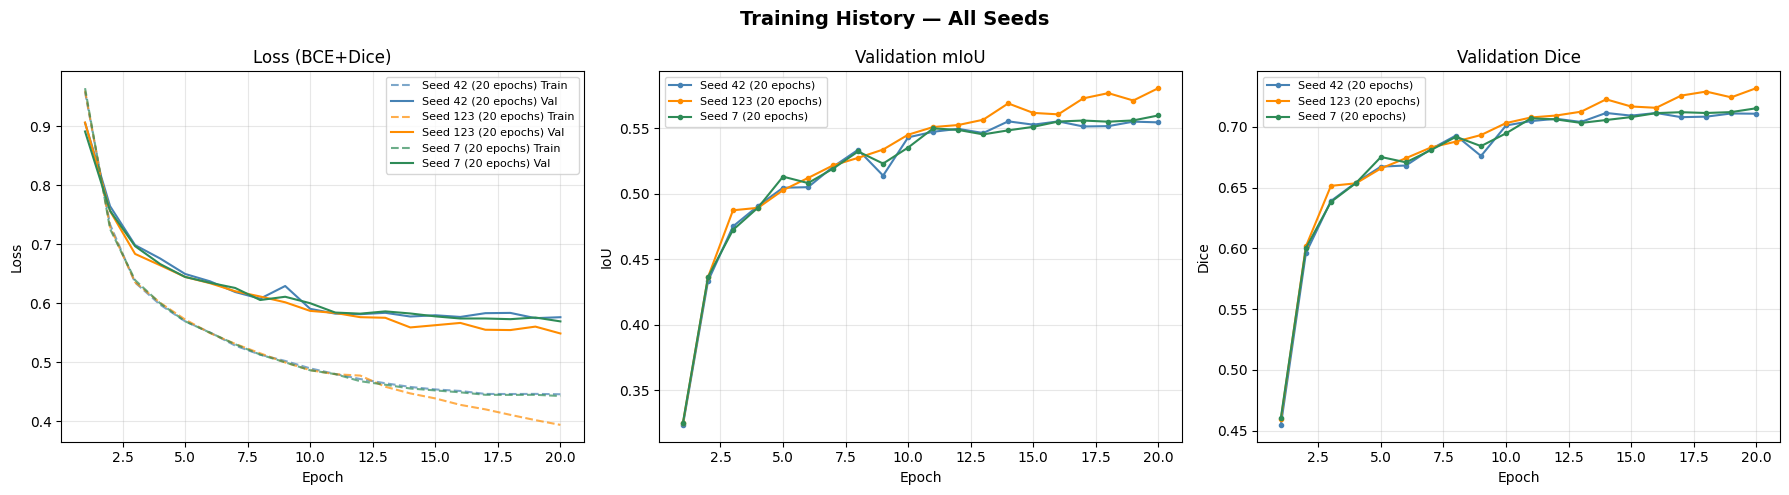


✅ Curves saved — 3/3 seeds plotted


In [7]:
import json
import os

SEEDS  = [42, 123, 7]
colors = ['steelblue', 'darkorange', 'seagreen']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Training History — All Seeds', fontsize=14, fontweight='bold')

plotted = 0
for i, seed in enumerate(SEEDS):
    hist_path = f"{BASE}/checkpoints/seed_{seed}/history.json"

    # ✅ Skip if this seed hasn't been trained yet
    if not os.path.exists(hist_path):
        print(f"⚠️  Seed {seed} not found — skipping")
        continue

    with open(hist_path) as f:
        h = json.load(f)

    # ✅ Skip if history is empty
    if not h['train_loss']:
        print(f"⚠️  Seed {seed} has empty history — skipping")
        continue

    epochs = range(1, len(h['train_loss']) + 1)
    color  = colors[i % len(colors)]
    label  = f"Seed {seed} ({len(h['train_loss'])} epochs)"

    axes[0].plot(epochs, h['train_loss'], label=f"{label} Train", color=color, linestyle='--', alpha=0.7)
    axes[0].plot(epochs, h['val_loss'],   label=f"{label} Val",   color=color, linestyle='-')
    axes[1].plot(epochs, h['val_iou'],    label=label,             color=color, marker='o', markersize=3)
    axes[2].plot(epochs, h['val_dice'],   label=label,             color=color, marker='o', markersize=3)

    print(f"✅ Seed {seed} plotted — Best IoU: {max(h['val_iou']):.4f}")
    plotted += 1

for ax, title, ylabel in zip(axes,
        ['Loss (BCE+Dice)', 'Validation mIoU', 'Validation Dice'],
        ['Loss', 'IoU', 'Dice']):
    ax.set_title(title)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()

if plotted > 0:
    plt.savefig(f"{BASE}/checkpoints/all_seeds_curves.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\n✅ Curves saved — {plotted}/{len(SEEDS)} seeds plotted")
else:
    print("❌ No seed history found — nothing to plot")

 Test Using Best Seed

In [9]:
import json
import os
import numpy as np

SEEDS = [42, 123, 7]

# Find best seed by reading saved history files — no all_results needed
best_seed = None
best_iou  = 0.0

for seed in SEEDS:
    hist_path = f"{BASE}/checkpoints/seed_{seed}/history.json"

    if not os.path.exists(hist_path):
        print(f"Seed {seed} not found — skipping")
        continue

    with open(hist_path) as f:
        h = json.load(f)

    if not h['val_iou']:
        print(f"Seed {seed} has empty history — skipping")
        continue

    seed_best = max(h['val_iou'])
    print(f"✅ Seed {seed} — Best IoU: {seed_best:.4f} ({len(h['val_iou'])} epochs)")

    if seed_best > best_iou:
        best_iou  = seed_best
        best_seed = seed

if best_seed is None:
    raise RuntimeError(" No trained seeds found — train at least one seed first!")

print(f"\nBest seed: {best_seed}  (IoU: {best_iou:.4f})")

# Load best model from checkpoint
best_ckpt = f"{BASE}/checkpoints/seed_{best_seed}/clipseg_best.pt"

if not os.path.exists(best_ckpt):
    raise FileNotFoundError(f"❌ Checkpoint not found: {best_ckpt}")

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model     = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")
model     = model.to(DEVICE)
model.load_state_dict(torch.load(best_ckpt, map_location=DEVICE), strict=False)
model.eval()
print(f"✅ Model loaded from: {best_ckpt}")

# Test DataLoader
test_ds     = DrywallDataset(D1_VALID_IMGS, D1_VALID_MASKS,
                              D2_VALID_IMGS, D2_VALID_MASKS)
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False, num_workers=2)

# Per-class evaluation
results = {'taping': {'iou': [], 'dice': []},
           'crack' : {'iou': [], 'dice': []}}

with torch.no_grad():
    for images, prompts, masks, labels in tqdm(test_loader, desc="Testing"):
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        inputs = processor(
            text=list(prompts),
            images=[T.ToPILImage()(img.cpu()) for img in images],
            return_tensors="pt", padding=True
        ).to(DEVICE)
        logits = model(**inputs).logits

        for i in range(len(images)):
            iou, dice = compute_metrics(logits[i].unsqueeze(0),
                                        masks[i].unsqueeze(0))
            results[labels[i]]['iou'].append(iou)
            results[labels[i]]['dice'].append(dice)

# Print results
print("\n" + "=" * 55)
print(f"   FINAL TEST RESULTS  (Best Seed: {best_seed})")
print("=" * 55)
print(f"{'Class':<15} {'mIoU':>10} {'Dice':>10} {'Samples':>10}")
print("-" * 55)

all_ious, all_dices = [], []
for label, m in results.items():
    if not m['iou']:
        print(f"{label:<15} {'N/A':>10} {'N/A':>10} {'0':>10}")
        continue
    miou  = np.mean(m['iou'])
    mdice = np.mean(m['dice'])
    all_ious.extend(m['iou'])
    all_dices.extend(m['dice'])
    print(f"{label:<15} {miou:>10.4f} {mdice:>10.4f} {len(m['iou']):>10}")

print("-" * 55)
print(f"{'Overall':<15} {np.mean(all_ious):>10.4f} "
      f"{np.mean(all_dices):>10.4f} {len(all_ious):>10}")
print("=" * 55)

✅ Seed 42 — Best IoU: 0.5552 (20 epochs)
✅ Seed 123 — Best IoU: 0.5804 (20 epochs)
✅ Seed 7 — Best IoU: 0.5596 (20 epochs)

Best seed: 123  (IoU: 0.5804)


Loading weights:   0%|          | 0/462 [00:00<?, ?it/s]

CLIPSegForImageSegmentation LOAD REPORT from: CIDAS/clipseg-rd64-refined
Key                                       | Status     |  | 
------------------------------------------+------------+--+-
clip.vision_model.embeddings.position_ids | UNEXPECTED |  | 
clip.text_model.embeddings.position_ids   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✅ Model loaded from: /content/drive/MyDrive/drywall-qa/checkpoints/seed_123/clipseg_best.pt
✅ Dataset: 498 samples loaded


Testing: 100%|██████████| 63/63 [00:29<00:00,  2.14it/s]


   FINAL TEST RESULTS  (Best Seed: 123)
Class                 mIoU       Dice    Samples
-------------------------------------------------------
taping              0.5611     0.7059        250
crack               0.5942     0.7345        248
-------------------------------------------------------
Overall             0.5776     0.7201        498


Visual Examples for Report

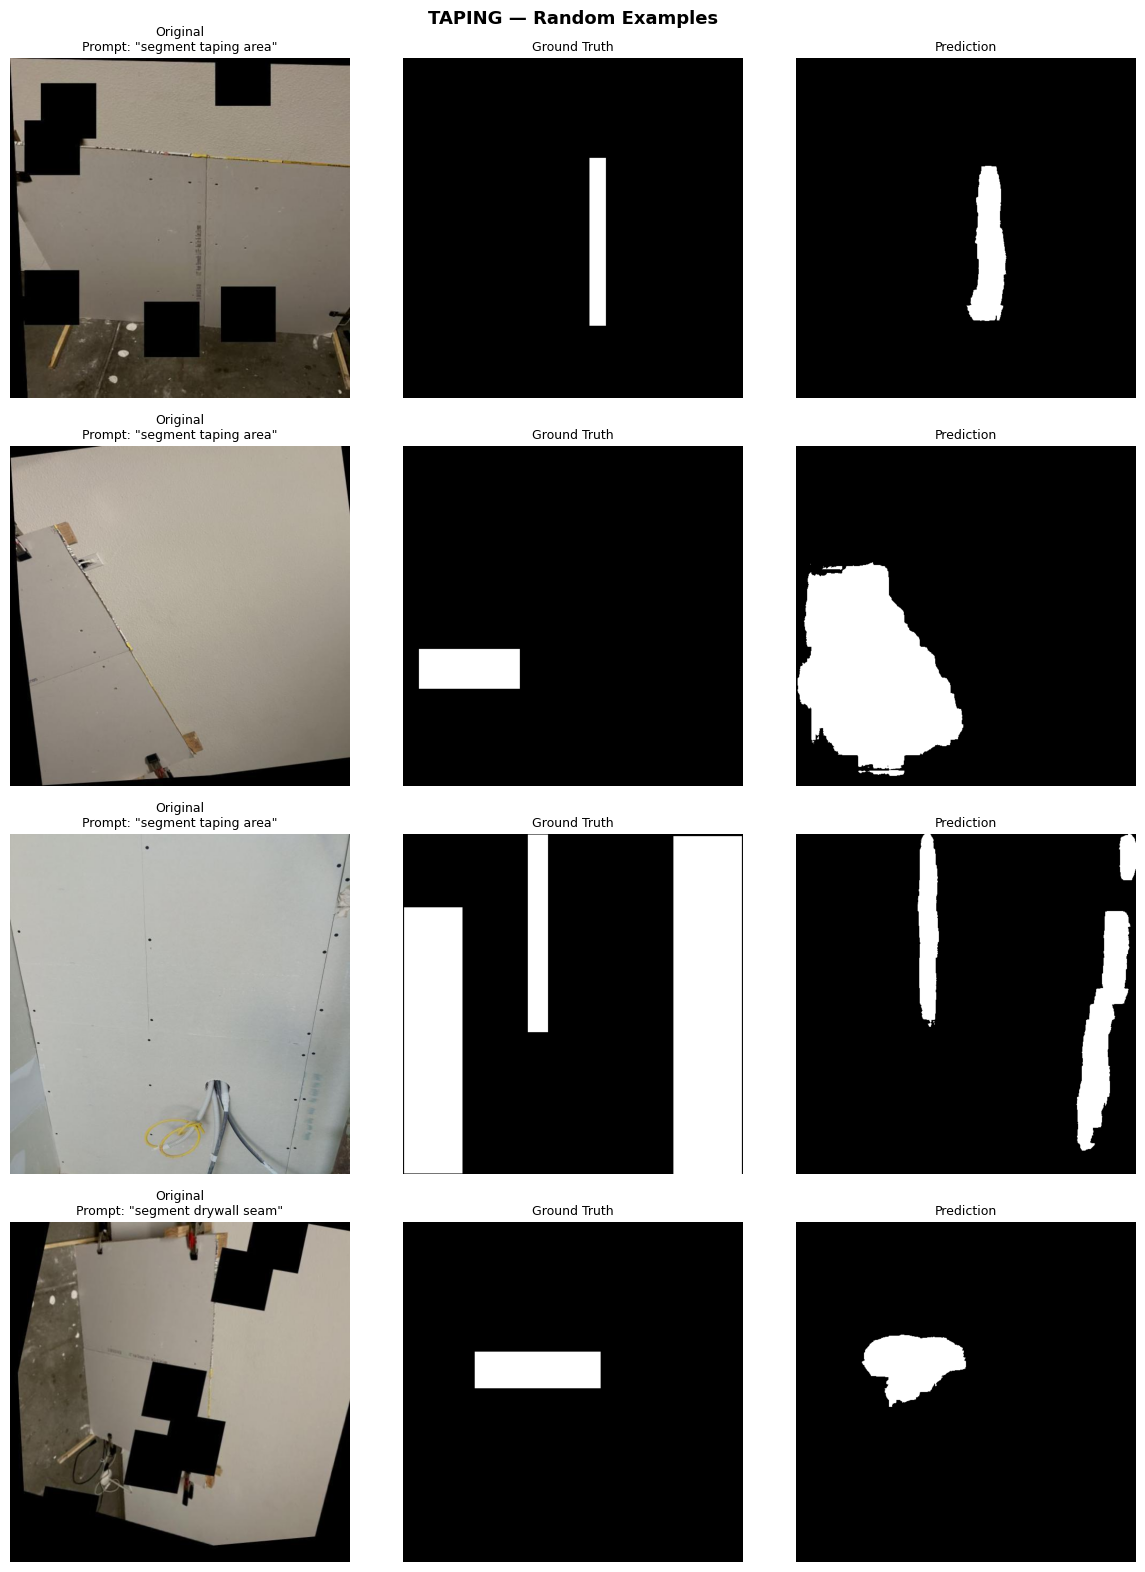

✅ Saved 4 examples → /content/drive/MyDrive/drywall-qa/predictions/taping_examples.png


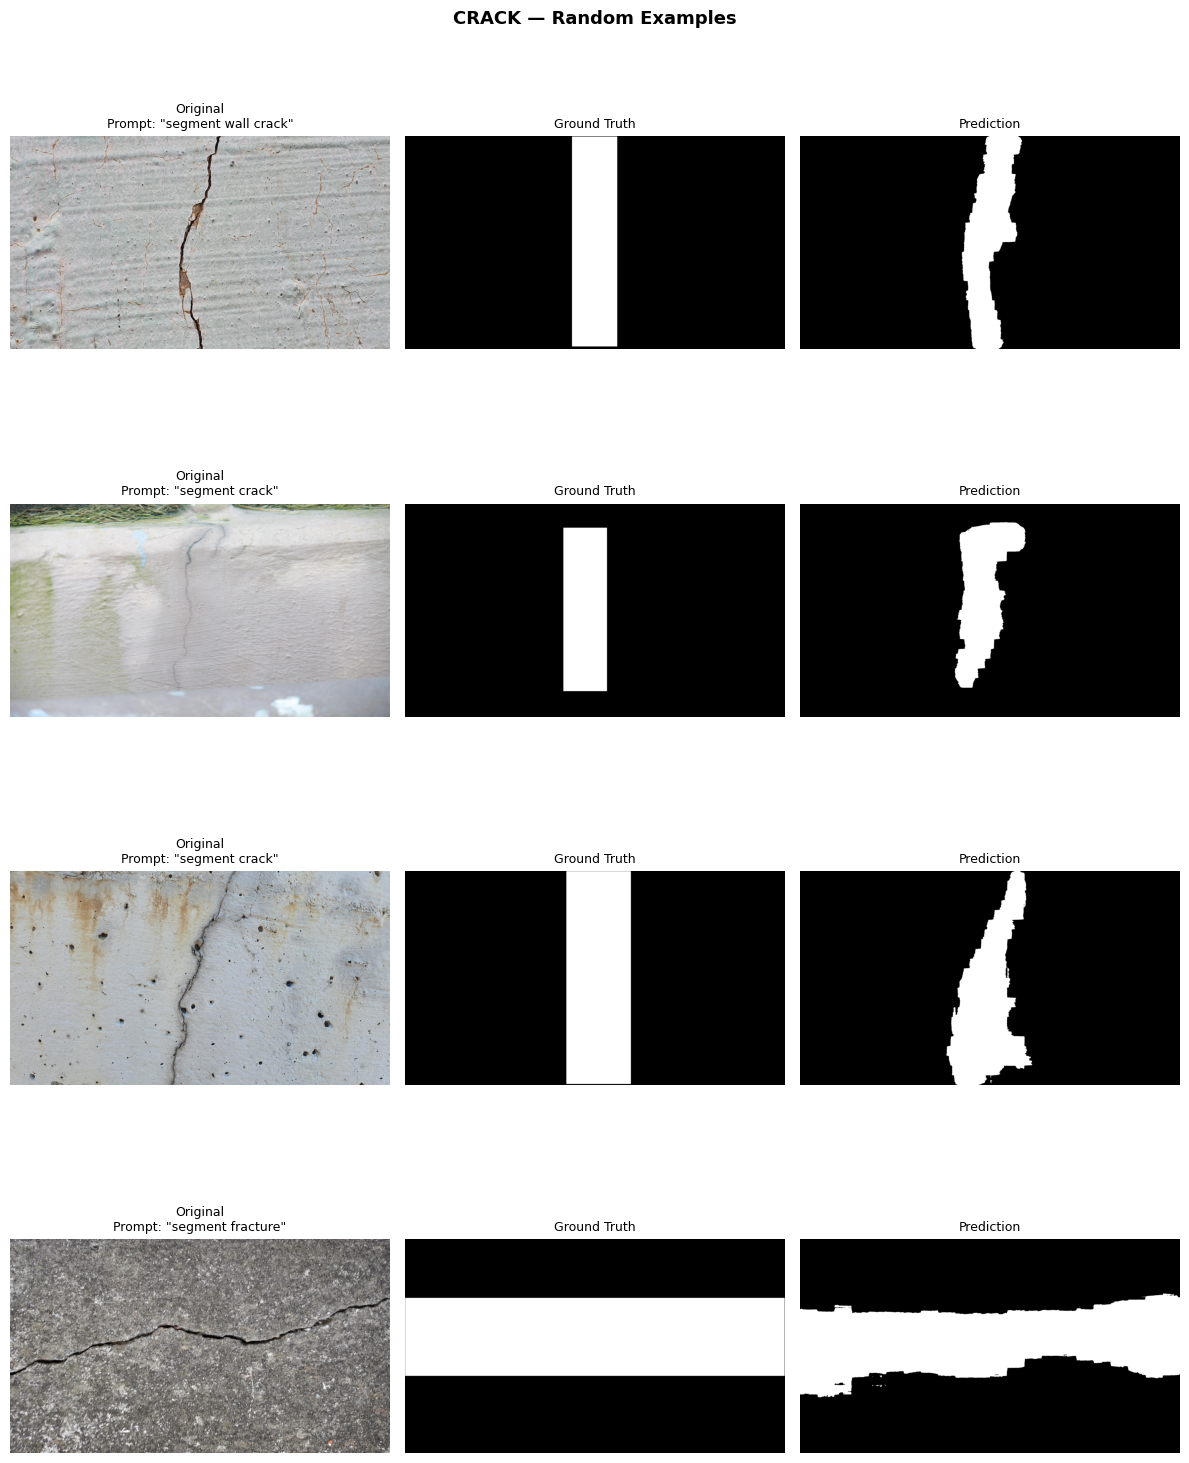

✅ Saved 4 examples → /content/drive/MyDrive/drywall-qa/predictions/crack_examples.png


In [10]:
def show_examples(imgs_dir, masks_dir, label, n=4):
    all_files = sorted([f for f in os.listdir(imgs_dir)
                        if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

    # Randomly pick n files
    sampled = random.sample(all_files, min(n, len(all_files)))

    fig, axes = plt.subplots(n, 3, figsize=(12, n * 4))
    fig.suptitle(f'{label.upper()} — Random Examples', fontsize=13, fontweight='bold')

    plotted = 0
    for img_file in sampled:
        if plotted >= n:
            break

        img_id    = os.path.splitext(img_file)[0]
        mask_path = os.path.join(masks_dir, img_id + '.png')

        if not os.path.exists(mask_path):
            continue

        # Randomly pick a prompt for this class
        prompt = random.choice(PROMPTS[label])

        image = Image.open(os.path.join(imgs_dir, img_file)).convert('RGB')
        gt    = Image.open(mask_path)

        inputs = processor(
            text=[prompt],
            images=[image],
            return_tensors="pt",
            padding=True
        ).to(DEVICE)

        with torch.no_grad():
            logits = model(**inputs).logits

        pred = torch.sigmoid(logits[0])
        pred = F.interpolate(
            pred.unsqueeze(0).unsqueeze(0),
            size=(image.size[1], image.size[0]),  # (H, W)
            mode='bilinear', align_corners=False
        ).squeeze()

        pred_mask = (pred.cpu().numpy() > 0.5).astype(np.uint8) * 255

        # Use plotted counter not i — so rows are always filled top to bottom
        axes[plotted][0].imshow(image)
        axes[plotted][0].set_title(f'Original\nPrompt: "{prompt}"', fontsize=9)
        axes[plotted][1].imshow(gt,        cmap='gray')
        axes[plotted][1].set_title('Ground Truth', fontsize=9)
        axes[plotted][2].imshow(pred_mask, cmap='gray')
        axes[plotted][2].set_title('Prediction', fontsize=9)

        for ax in axes[plotted]:
            ax.axis('off')

        plotted += 1

    # ✅ Hide any unused rows cleanly
    for j in range(plotted, n):
        for ax in axes[j]:
            ax.axis('off')

    plt.tight_layout()
    save_path = f"{BASE}/predictions/{label}_examples.png"
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f" Saved {plotted} examples → {save_path}")


# Call without hardcoded prompt — function picks randomly
show_examples(D1_VALID_IMGS, D1_VALID_MASKS, label='taping')
show_examples(D2_VALID_IMGS, D2_VALID_MASKS, label='crack')

Save Prediction Masks (random prompts)

In [11]:
def save_predictions(imgs_dir, masks_dir, label, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    img_files  = sorted([f for f in os.listdir(imgs_dir)
                         if f.lower().endswith(('.jpg','.jpeg','.png'))])
    saved      = 0
    saved_meta = []  # track which prompt was used for each image

    for idx, img_file in enumerate(tqdm(img_files, desc=f"Saving {label} masks")):
        img_id    = os.path.splitext(img_file)[0]
        mask_path = os.path.join(masks_dir, img_id + '.png')
        if not os.path.exists(mask_path):
            continue

        # Randomly pick a prompt for this class
        prompt      = random.choice(PROMPTS[label])
        prompt_slug = prompt.replace(" ", "_")

        # Load image
        image     = Image.open(os.path.join(imgs_dir, img_file)).convert('RGB')
        orig_size = image.size  # (W, H)

        # Run inference
        inputs = processor(
            text=[prompt],
            images=[image],
            return_tensors="pt",
            padding=True
        ).to(DEVICE)

        with torch.no_grad():
            logits = model(**inputs).logits  # [1, H, W]

        # Resize prediction back to original image size
        pred = torch.sigmoid(logits[0])
        pred = F.interpolate(
            pred.unsqueeze(0).unsqueeze(0),
            size=(orig_size[1], orig_size[0]),
            mode='bilinear',
            align_corners=False
        ).squeeze()

        binary_mask = (pred.cpu().numpy() > 0.5).astype(np.uint8) * 255

        # Save with numeric id + prompt used
        numeric_id = str(idx + 1).zfill(4)
        out_name   = f"{numeric_id}__{prompt_slug}.png"
        Image.fromarray(binary_mask).save(os.path.join(output_dir, out_name))

        # Track metadata
        saved_meta.append({
            'idx'       : numeric_id,
            'img_file'  : img_file,
            'prompt'    : prompt,
            'mask_name' : out_name
        })
        saved += 1

    # Save metadata so we know which prompt was used for each image
    meta_path = os.path.join(output_dir, 'metadata.json')
    with open(meta_path, 'w') as f:
        json.dump(saved_meta, f, indent=2)

    print(f"Saved {saved} masks  →  {output_dir}")
    print(f" Metadata saved →  {meta_path}")
    return saved_meta


PRED_DIR = f"{BASE}/predictions"

# Save taping predictions
taping_meta = save_predictions(
    D1_VALID_IMGS, D1_VALID_MASKS,
    label='taping',
    output_dir=f"{PRED_DIR}/taping"
)

# Save crack predictions
crack_meta = save_predictions(
    D2_VALID_IMGS, D2_VALID_MASKS,
    label='crack',
    output_dir=f"{PRED_DIR}/cracks"
)

Saving taping masks: 100%|██████████| 250/250 [00:57<00:00,  4.33it/s]


Saved 250 masks  →  /content/drive/MyDrive/drywall-qa/predictions/taping
 Metadata saved →  /content/drive/MyDrive/drywall-qa/predictions/taping/metadata.json


Saving crack masks: 100%|██████████| 248/248 [01:26<00:00,  2.86it/s]

Saved 248 masks  →  /content/drive/MyDrive/drywall-qa/predictions/cracks
 Metadata saved →  /content/drive/MyDrive/drywall-qa/predictions/cracks/metadata.json


Display 4 Random Examples Per Class

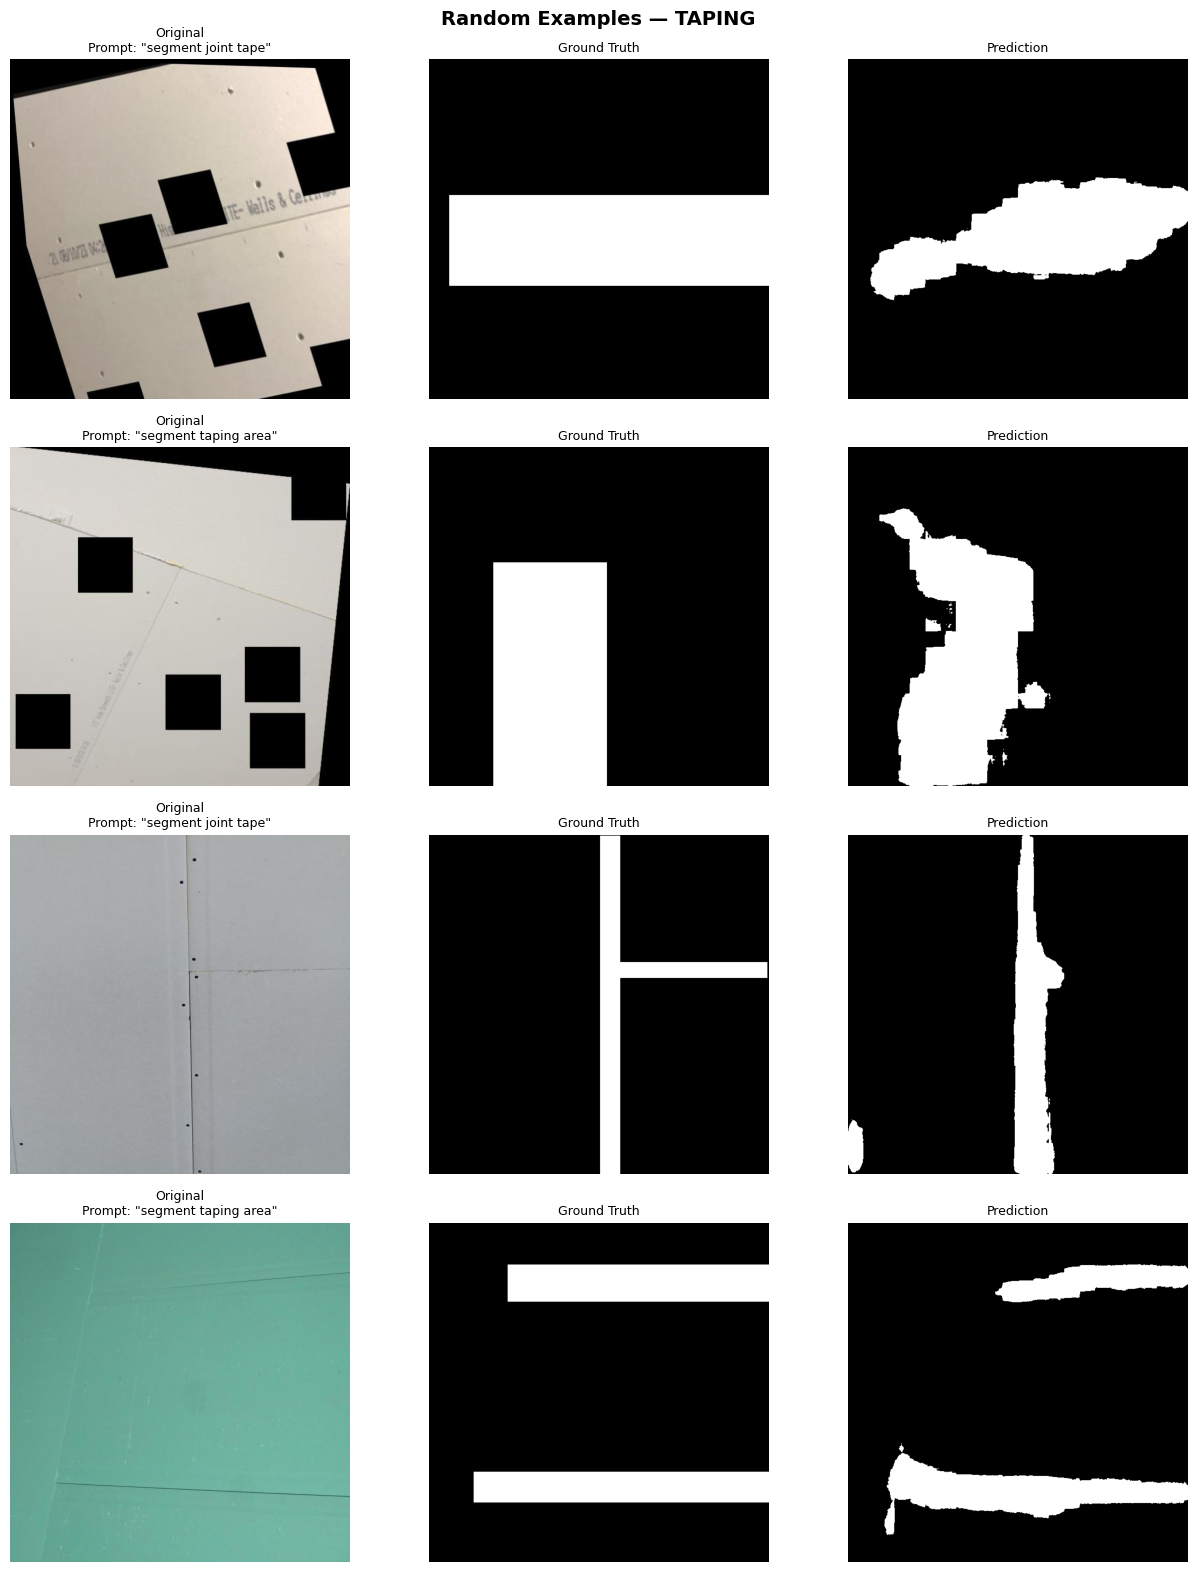

✅ Saved → /content/drive/MyDrive/drywall-qa/predictions/taping_random_examples.png


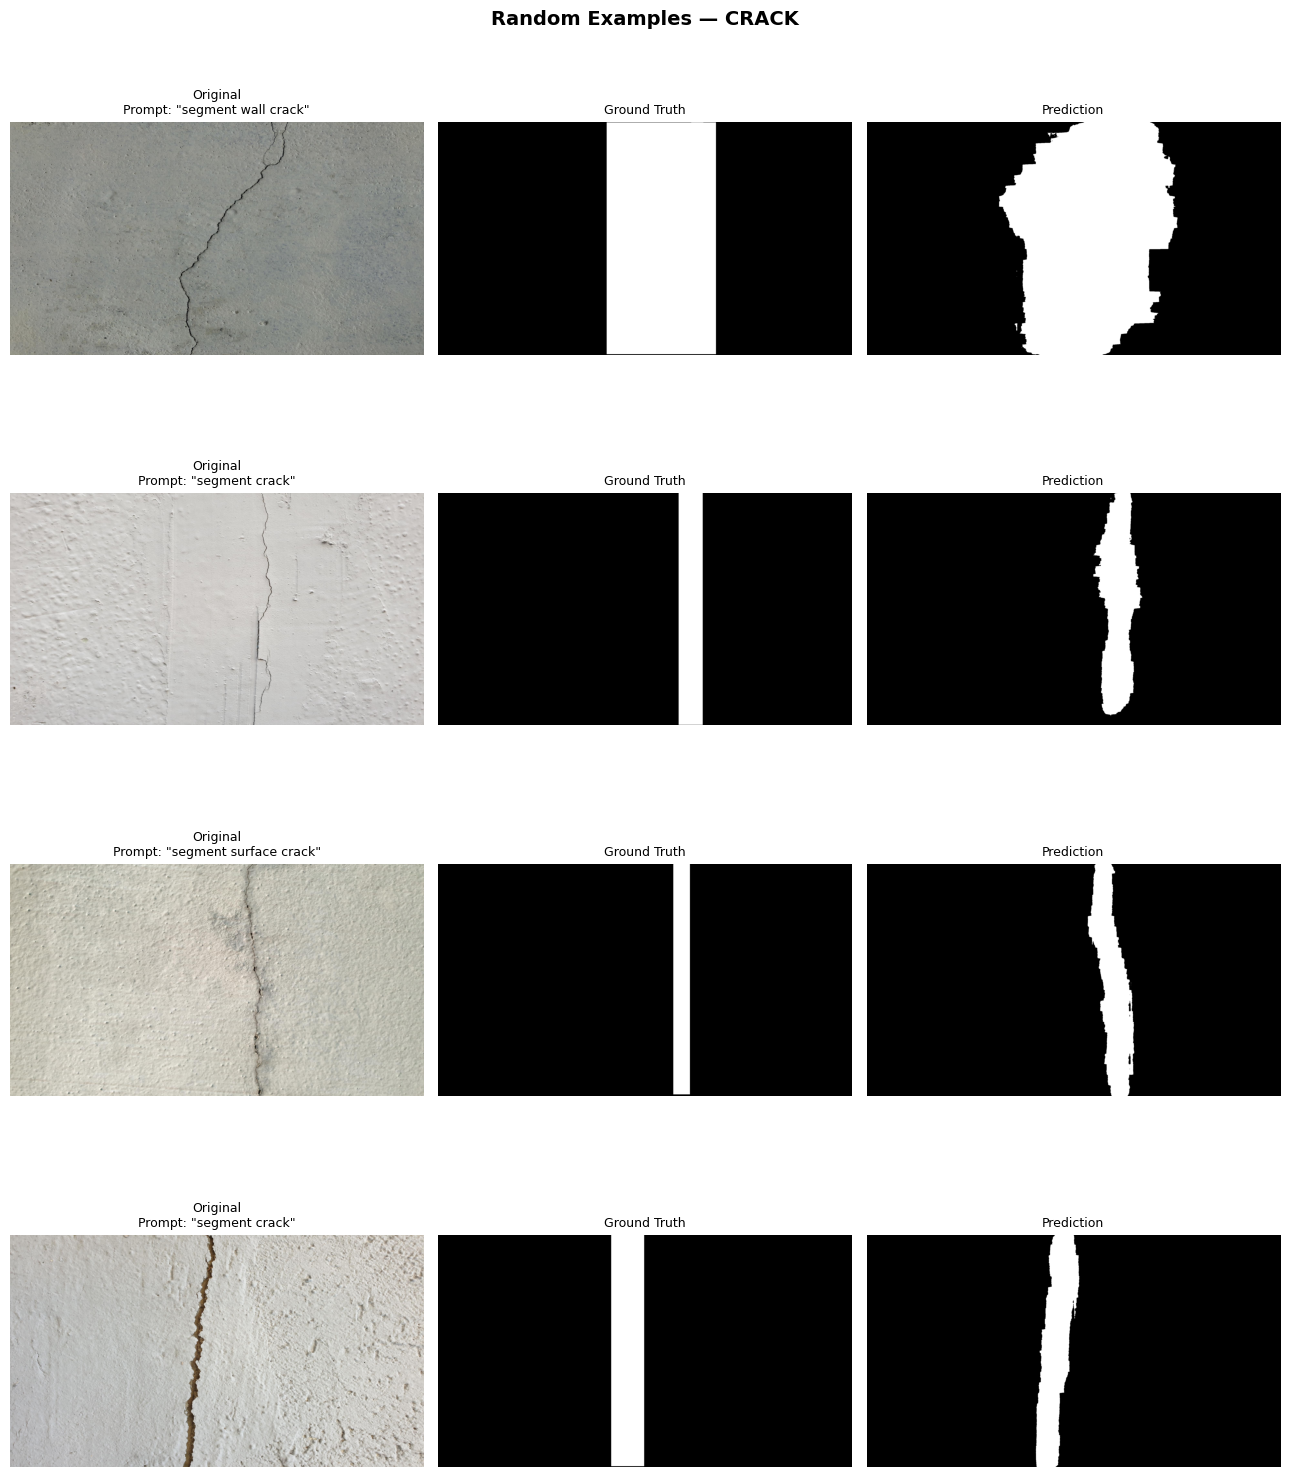

✅ Saved → /content/drive/MyDrive/drywall-qa/predictions/crack_random_examples.png


In [12]:
def visualize_random_examples(imgs_dir, masks_dir, pred_dir, meta, label, n=4):

    # Randomly pick n entries from metadata
    sampled = random.sample(meta, min(n, len(meta)))

    fig, axes = plt.subplots(n, 3, figsize=(13, n * 4))
    fig.suptitle(f'Random Examples — {label.upper()}',
                 fontsize=14, fontweight='bold')

    for i, entry in enumerate(sampled):
        img_file  = entry['img_file']
        prompt    = entry['prompt']
        mask_name = entry['mask_name']

        img_path  = os.path.join(imgs_dir, img_file)
        mask_path = os.path.join(masks_dir, os.path.splitext(img_file)[0] + '.png')
        pred_path = os.path.join(pred_dir,  mask_name)

        if not os.path.exists(img_path) or \
           not os.path.exists(mask_path) or \
           not os.path.exists(pred_path):
            continue

        img  = Image.open(img_path).convert('RGB')
        gt   = Image.open(mask_path)
        pred = Image.open(pred_path)

        axes[i][0].imshow(img)
        axes[i][0].set_title(f'Original\nPrompt: "{prompt}"', fontsize=9)

        axes[i][1].imshow(gt,   cmap='gray')
        axes[i][1].set_title('Ground Truth', fontsize=9)

        axes[i][2].imshow(pred, cmap='gray')
        axes[i][2].set_title('Prediction', fontsize=9)

        for ax in axes[i]:
            ax.axis('off')

    plt.tight_layout()
    save_path = f"{PRED_DIR}/{label}_random_examples.png"
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved → {save_path}")


# Display taping examples
visualize_random_examples(
    D1_VALID_IMGS, D1_VALID_MASKS,
    f"{PRED_DIR}/taping",
    meta=taping_meta,
    label='taping'
)

# Display crack examples
visualize_random_examples(
    D2_VALID_IMGS, D2_VALID_MASKS,
    f"{PRED_DIR}/cracks",
    meta=crack_meta,
    label='crack'
)